In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, fbeta_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from itertools import product
from umap import UMAP

### Functions

In [65]:
def plot_confustion_matrix(y_true, y_pred):
    c_matrix = confusion_matrix(y_true, y_pred)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = [f'Count {value}' for value in c_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in c_matrix.flatten() / np.sum(c_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(c_matrix, annot=labels, fmt='', cmap='Blues')
    plt.show()

### Data analysis

In [66]:
test_df = pd.read_csv('./data/class_test.csv')
train_df = pd.read_csv('./data/class_train.csv')
concat_df = pd.concat([test_df, train_df])
concat_df.shape

(116, 160)

In [67]:
classes = concat_df['Outcome'].unique()
unique_dtypes = concat_df.dtypes.unique()
concat_class_counts = concat_df['Outcome'].value_counts()
train_class_counts = train_df['Outcome'].value_counts()
test_class_counts = test_df['Outcome'].value_counts()
contains_null_values = concat_df.isnull().values.any()
list_to_str = lambda x: ", ".join([str(item) for item in x])
class_counts_to_list = lambda class_count: [f"{key}: {item}" for key, item in class_count.items()] 

print(f'The dataset contains: {len(classes)} classes [{list_to_str(classes)}]')
print(f'The dataset contains: {len(unique_dtypes)} different datatypes [{list_to_str(unique_dtypes)}]')
print(f'Concatenated dataset contains: {concat_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(concat_class_counts))}]')
print(f'Train dataset contains: {train_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(train_class_counts))}]')
print(f'Test dataset contains: {test_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(test_class_counts))}]')
print(f'The dataset has {"not " if not contains_null_values else ""}null values.')


The dataset contains: 2 classes [0, 1]
The dataset contains: 2 different datatypes [float64, int64]
Concatenated dataset contains: 116 rows with the class balances [1: 64, 0: 52]
Train dataset contains: 91 rows with the class balances [1: 56, 0: 35]
Test dataset contains: 25 rows with the class balances [0: 17, 1: 8]
The dataset has not null values.


### Preprocessing

In [68]:
x = concat_df.copy()
y = x.pop('Outcome')

# scale the data
scaler = StandardScaler()
scaled_x = scaler.fit_transform(x)

##### Hanterar först obalans mellan training data och test data

In [69]:
# With the concatenated dataset we can now split the data more evenly with the use of stratify.
x_train, x_test, y_train, y_test = train_test_split(scaled_x, y, test_size=0.2, random_state=42, shuffle=True, stratify=y)

In [70]:
new_train_class_balance = y_train.value_counts()
new_test_class_balances = y_test.value_counts()


print(f'Old Train dataset contains: {train_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(train_class_counts))}]')
print(f'Old Test dataset contains: {test_df.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(test_class_counts))}]')
print('-' * 80)
print(f'New Train dataset contains: {y_train.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(new_train_class_balance))}]')
print(f'New Test dataset contains: {y_test.shape[0]} rows with the class balances [{list_to_str(class_counts_to_list(new_test_class_balances))}]')
print('-' * 80)
print(f'New train and test are more balanced.')


Old Train dataset contains: 91 rows with the class balances [1: 56, 0: 35]
Old Test dataset contains: 25 rows with the class balances [0: 17, 1: 8]
--------------------------------------------------------------------------------
New Train dataset contains: 92 rows with the class balances [1: 51, 0: 41]
New Test dataset contains: 24 rows with the class balances [1: 13, 0: 11]
--------------------------------------------------------------------------------
New train and test are more balanced.


## baseline

In [71]:
clf_svm = SVC(kernel='rbf')
clf_svm.fit(x_train, y_train)

train_score = clf_svm.score(x_train, y_train)
test_score = clf_svm.score(x_test, y_test)
predictions = clf_svm.predict(x_test)

f_one_score = f1_score(y_test, predictions)
f_beta_score = fbeta_score(y_test, predictions, beta=0.5)


print(f'Train score: {train_score}')
print(f'Test score: {test_score}')
print('-' * 80)
print(f'The f1 score is: {f_one_score}')
print(f'The fbeta scora is: {f_beta_score}')

Train score: 0.9347826086956522
Test score: 0.625
--------------------------------------------------------------------------------
The f1 score is: 0.608695652173913
The fbeta scora is: 0.6603773584905661


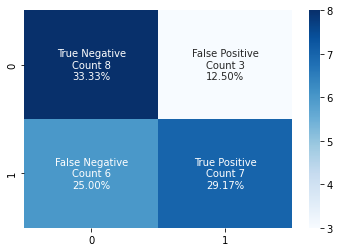

In [72]:
c_matrix = plot_confustion_matrix(y_test, predictions)

## Model

### Grid Search within range of values to find best hypeparameters.

In [93]:
kernels = ['rbf']
gammas = [1.2, 0.5, 0.3]
cs = [0.2*x + 1 for x in range(30)]
variations = list(product(kernels, gammas, cs))

scores = [f1_score(y_test, SVC(kernel=k, C=c, gamma=g).fit(x_train, y_train).predict(x_test), average='weighted') for k, g, c in variations]

print(np.unique(scores, return_counts=True))
print(f'The best score is {np.max(scores)}')

(array([0.38063063]), array([90], dtype=int64))
The best score is 0.38063063063063063


In [94]:
kernels = ['linear']
cs = np.linspace(0.000000001, 5, num=10)
vaiations = list(product(kernels, cs))
scores = [f1_score(y_test, SVC(kernel=k, C=c).fit(x_train, y_train).predict(x_test), average='weighted') for k, g, c in variations]
print(np.unique(scores, return_counts=True))
print(f'The best score is {np.max(scores)}')

(array([0.58333333, 0.60009488, 0.61479129, 0.62304348, 0.62565217,
       0.65185185, 0.66190476, 0.66666667, 0.70679012]), array([ 3, 51,  3,  6,  6,  6,  9,  3,  3], dtype=int64))
The best score is 0.70679012345679


##### To get better scores we need to for example reduce noise in the data, more on that in VG version.